Importing libraries

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress tracking

Loading Image

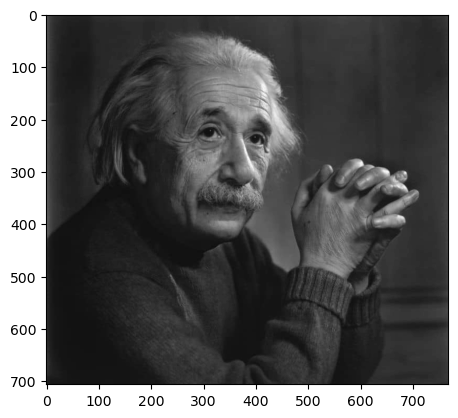

In [23]:
gray_image = cv2.imread(r"C:\Users\91878\Downloads\Albert_Einstein.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(gray_image,cmap='gray')

In [24]:
# Gaussian function to generate kernel for blurring
def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - (size - 1) / 2)**2 + (y - (size - 1) / 2)**2) / (2 * sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

# Apply Gaussian blur on an image
def gaussian_blur(image, sigma, kernel_size=5):
    kernel = gaussian_kernel(kernel_size, sigma)
    return cv2.filter2D(image, -1, kernel)

# Build Gaussian pyramid (downscaled images)
def build_gaussian_pyramid(image, levels=5, sigma=1.6):
    pyramid = [image]
    for i in tqdm(range(1, levels), desc="Building Gaussian Pyramid"):
        image = gaussian_blur(image, sigma)
        pyramid.append(image)
    return pyramid

# Build DoG pyramid (difference of Gaussian)
def build_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for i in tqdm(range(1, len(gaussian_pyramid)), desc="Building DoG Pyramid"):
        dog_image = cv2.subtract(gaussian_pyramid[i], gaussian_pyramid[i - 1])
        dog_pyramid.append(dog_image)
    return dog_pyramid

In [25]:
def detect_keypoints(dog_pyramid, response_threshold=0.5, keypoint_size=2.0, nms_radius=5, max_keypoints=600):
    keypoints = []

    # Iterate over each layer of DoG pyramid (excluding the first and last layer)
    for i in tqdm(range(1, len(dog_pyramid) - 1), desc="Detecting Keypoints"):
        for x in range(1, dog_pyramid[i].shape[0] - 1):
            for y in range(1, dog_pyramid[i].shape[1] - 1):
                # Local neighborhood to check maxima or minima
                patch = dog_pyramid[i-1][x-1:x+2, y-1:y+2]
                local_max = np.max(patch)
                local_min = np.min(patch)

                if dog_pyramid[i][x, y] == local_max or dog_pyramid[i][x, y] == local_min:
                    if abs(dog_pyramid[i][x, y]) > response_threshold:
                        # Create keypoint with response value
                        kp = cv2.KeyPoint(x=float(y), y=float(x), size=keypoint_size, angle=-1)
                        kp.response = abs(dog_pyramid[i][x, y])  # Using the response as an importance measure
                        keypoints.append(kp)

    # Sort keypoints by their response and select top N (500 in this case)
    keypoints = sorted(keypoints, key=lambda kp: kp.response, reverse=True)[:max_keypoints]

    return keypoints

In [26]:
# Sobel kernel for detecting edges
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

def apply_sobel(patch):
    grad_x = cv2.filter2D(patch, -1, sobel_x)
    grad_y = cv2.filter2D(patch, -1, sobel_y)
    return grad_x, grad_y

In [27]:
def compute_histogram(magnitude, orientation, bins=8):
    hist = np.zeros(bins)
    bin_width = 360 / bins
    for i in range(magnitude.shape[0]):
        for j in range(magnitude.shape[1]):
            angle = orientation[i, j] % 360
            bin_index = int(angle // bin_width)
            hist[bin_index] += magnitude[i, j]
    return hist

In [28]:
def compute_descriptors(image, keypoints, patch_size=16):
    descriptors = []
    half_patch = patch_size // 2
    for kp in tqdm(keypoints, desc="Computing Descriptors"):
        x, y = int(kp.pt[1]), int(kp.pt[0])
        if x - half_patch >= 0 and x + half_patch < image.shape[0] and y - half_patch >= 0 and y + half_patch < image.shape[1]:
            patch = image[x - half_patch:x + half_patch, y - half_patch:y + half_patch]
            grad_x, grad_y = apply_sobel(patch)
            gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
            gradient_orientation = np.arctan2(grad_y, grad_x) * (180 / np.pi)
            descriptor = compute_histogram(gradient_magnitude, gradient_orientation)
            descriptors.append(descriptor)
    return np.array(descriptors)

In [29]:
gaussian_pyramid = build_gaussian_pyramid(gray_image)
dog_pyramid = build_dog_pyramid(gaussian_pyramid)
sift_keypoints = detect_keypoints(dog_pyramid)
sift_descriptors = compute_descriptors(gray_image, sift_keypoints)

Computing Descriptors: 100%|████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 739.81it/s]


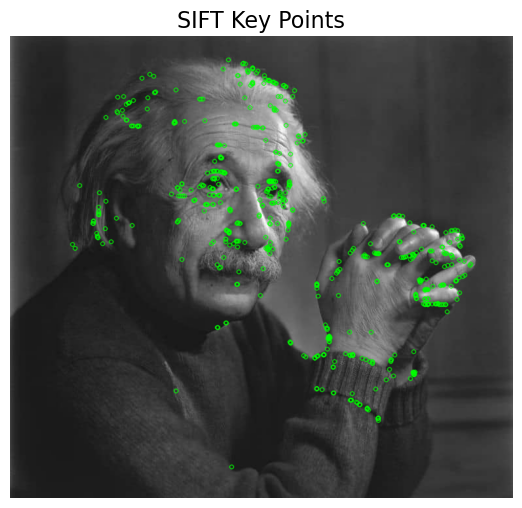

In [30]:
plt.figure(figsize=(8, 6))
plt.imshow(cv2.drawKeypoints(gray_image, sift_keypoints, None, color=(0, 255, 0)))
plt.title("SIFT Key Points", fontsize=16)
plt.axis("off")  # Hide axes
plt.show()

In [33]:
# Bag of Words (BoW) using KMeans from scratch
def apply_bow(descriptors, num_clusters=50):
    # Perform KMeans clustering from scratch
    # Initialize random cluster centers
    np.random.seed(0)
    initial_centers = descriptors[np.random.choice(descriptors.shape[0], num_clusters, replace=False)]

    prev_centers = np.zeros_like(initial_centers)
    max_iters = 100
    for i in range(max_iters):
        # Assign descriptors to the nearest cluster center
        distances = np.linalg.norm(descriptors[:, np.newaxis] - initial_centers, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update the cluster centers
        for j in range(num_clusters):
            cluster_points = descriptors[labels == j]
            if len(cluster_points) > 0:
                initial_centers[j] = np.mean(cluster_points, axis=0)

        # Convergence check
        if np.allclose(initial_centers, prev_centers):
            break
        prev_centers = initial_centers.copy()

    # Create BoW histogram by counting the frequency of cluster assignments
    histogram, _ = np.histogram(labels, bins=num_clusters, range=(0, num_clusters))

    return histogram
bow_histogram= apply_bow(sift_descriptors, num_clusters=50)

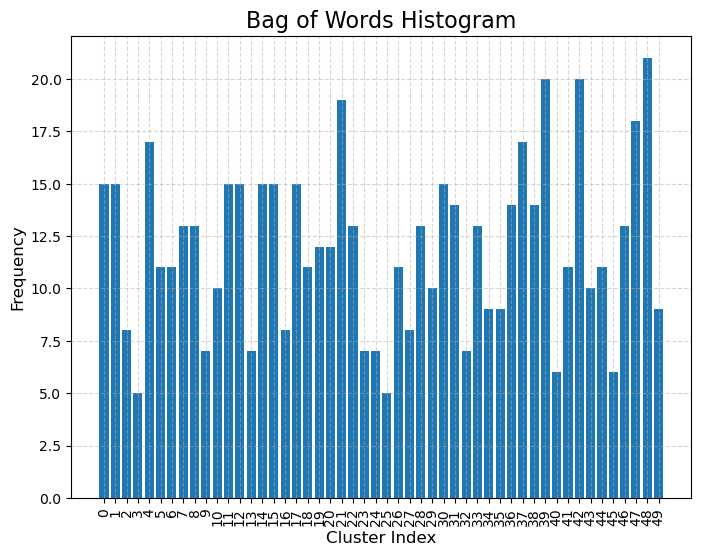

In [34]:
# Bag of Words Histogram Plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(bow_histogram)), bow_histogram)
plt.title("Bag of Words Histogram", fontsize=16)
plt.xlabel("Cluster Index", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Adjusting x-ticks to prevent overlap
plt.xticks(range(len(bow_histogram)), rotation=90)
plt.grid(True, axis='both', linestyle='--', alpha=0.5)
plt.show()

In [37]:
def compute_hog(image, cell_size=(3, 3), block_size=(2, 2), nbins=9):
    # Convert to gradients in x and y direction
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute magnitude and angle
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    angle = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 180

    # Compute HOG features for each cell
    height, width = image.shape
    cells_x = width // cell_size[1]
    cells_y = height // cell_size[0]

    hog_image = np.zeros((height, width), dtype=np.float32)
    for i in range(cells_y):
        for j in range(cells_x):
            # Extract the patch for the current cell
            cell_magnitude = magnitude[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            cell_angle = angle[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]

            # Compute histogram of gradients for the cell
            hist = np.zeros(nbins)
            bin_width = 180 / nbins
            for m in range(cell_magnitude.shape[0]):
                for n in range(cell_magnitude.shape[1]):
                    bin_index = int(cell_angle[m, n] // bin_width)  # Find the corresponding bin
                    hist[bin_index] += cell_magnitude[m, n]

            # Normalize histogram 
            hist = hist / np.linalg.norm(hist) if np.linalg.norm(hist) > 0 else hist

            # Update the HOG image (just for visualization here)
            hog_image[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]] = hist.reshape(cell_size)

    return hog_image
hog_image = compute_hog(gray_image)

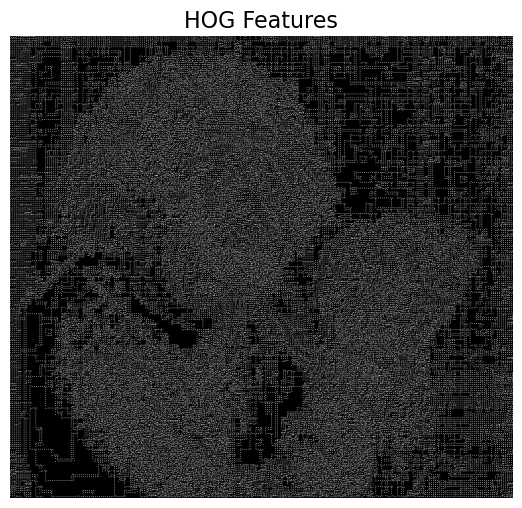

In [38]:
# HOG Features Plot
plt.figure(figsize=(8, 6))
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.title("HOG Features", fontsize=16)
plt.axis("off")  # Hide axes
plt.show()